In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/measurements/noise_model_gem/master_thesis_qaoa'))

In [2]:
import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit_optimization.algorithms import GoemansWilliamsonOptimizer

from helpers import *
from shared.QiskitMaxcut import *
from shared.graph_helper import *
from shared.gem.gem_instance import GEMInstance

In [3]:
%load_ext autoreload
%autoreload 2

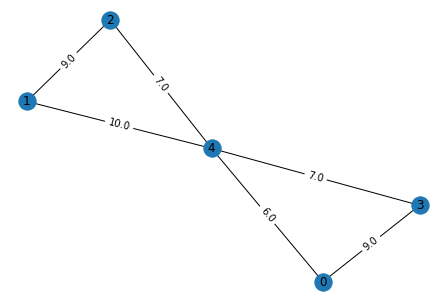

In [4]:
# ---- Define graph and MaxCut ----
filename = "graph_05_06_02_w.txt"
graph = load_nx_graph_from(f"data/{filename}")
opt_max_cut = -get_max_cut(graph.name)
max_cut = Maxcut(graph, opt_max_cut)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

In [5]:
BACKEND, EVAL_NUM, MAX_ITER, MAX_P, SHOTS = load_configs()
display_configs()
all_results = {}
gem_instance = GEMInstance()

Backend = Simulator_Noise_Model with GEM
EVAL_NUM = 1
MAX_ITER = 1
MAX_P = 2
SHOTS = 1024


In [6]:
from helpers.qaoa_helper import *

In [7]:
import helpers

In [49]:
betas = np.linspace(-np.pi,np.pi, 64)
gammas = np.linspace(-np.pi,np.pi, 64)

In [50]:
betas

array([-3.14159265, -3.04185955, -2.94212645, -2.84239335, -2.74266025,
       -2.64292715, -2.54319405, -2.44346095, -2.34372785, -2.24399475,
       -2.14426165, -2.04452855, -1.94479545, -1.84506235, -1.74532925,
       -1.64559615, -1.54586305, -1.44612995, -1.34639685, -1.24666375,
       -1.14693065, -1.04719755, -0.94746445, -0.84773135, -0.74799825,
       -0.64826515, -0.54853205, -0.44879895, -0.34906585, -0.24933275,
       -0.14959965, -0.04986655,  0.04986655,  0.14959965,  0.24933275,
        0.34906585,  0.44879895,  0.54853205,  0.64826515,  0.74799825,
        0.84773135,  0.94746445,  1.04719755,  1.14693065,  1.24666375,
        1.34639685,  1.44612995,  1.54586305,  1.64559615,  1.74532925,
        1.84506235,  1.94479545,  2.04452855,  2.14426165,  2.24399475,
        2.34372785,  2.44346095,  2.54319405,  2.64292715,  2.74266025,
        2.84239335,  2.94212645,  3.04185955,  3.14159265])

In [9]:
# (beta, gamma, value)
landscape = []

In [10]:
16*16

256

In [51]:
step_size = 0.1
gamma_range = np.arange(-np.pi, np.pi, step_size)
beta_range = np.arange(-np.pi, np.pi, step_size)
l_betas, l_gammas = np.meshgrid(betas, gammas)

In [52]:
len(beta_range)

63

In [53]:
f1_temp = np.zeros(l_betas.shape)
f1_temp

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [54]:
for beta in range(0, len(betas)):
    for gamma in range(0, len(gammas)):
        qaoa = create_qaoa(initial_point=[betas[beta],gammas[gamma]])
        mean, ar, r = helpers.qaoa_helper._run_qaoa_evaluation(max_cut, qaoa, gem_instance)
        #landscape.append( (beta, gamma, mean) )
        f1_temp[beta, gamma] = mean
        print(f".",end='')
    print()

................................................................
................................................................
................................................................
................................................................
................................................................
................................................................
................................................................
................................................................
................................................................
................................................................
................................................................
................................................................
................................................................
................................................................
................................................................
.........................

In [46]:
import plotly.graph_objects as go
from matplotlib import pyplot as plt

def get_hover_template():
    return "γ: %{x:.2f}<br>β: %{y:.2f}<br>Exp.Value: %{z:.2f}<extra></extra>"

def get_text_hover_template():
    return get_hover_template().replace('z','text')

def plot_landscape_3d(x,y,z):
    # Plot landscape in 3D 

    fig_landscape_3d = go.Figure(data=go.Surface(x=x, y=y, z=z))

    fig_landscape_3d.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))


    fig_landscape_3d.update_layout(title="QAOA MaxCut Landscape 3D", scene=dict(
        xaxis_title="γ",
        yaxis_title="β",
        zaxis_title="expectation value"
    ))
    
    fig_landscape_3d.show()

In [55]:
plot_landscape_3d(betas, gammas, f1_temp)

In [56]:
# Save result matrix 
#with open('landscape_simulator_toronto_noise_graph_05_06_02_w_results.npy', 'wb') as f:
#    np.save(f, f1_temp)

In [59]:
    
def plot_heatmap(x,y,z, show=False):
    # Plot Heatmap 
    fig_heatmap = go.Figure(data=go.Heatmap(
                            z=z, y=y, x=x, type = 'heatmap', colorscale = 'viridis', name="Landscape",
                            hovertemplate=get_hover_template()),
                           
                           )

    # Update Layout
    fig_heatmap.update_layout(
        title="QAOA MaxCut Landscape 2D (p=1)", width=1000, height=700, yaxis_title="β", xaxis_title="γ"
    )

    fig_heatmap.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.2
    ))
    if show:
        fig_heatmap.show()
    
    return fig_heatmap

In [60]:
plot_heatmap(betas, gammas, f1_temp, True)

In [61]:
np.min(f1_temp)

-31.362304687500004